#  Space fish  

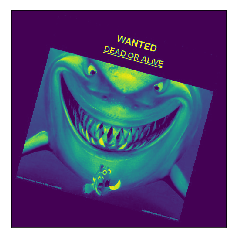

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage.io import imread

img=imread('fish_rotated.jpg', as_grey=True)
imgplot = plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## Radon transformation

/usr/local/lib/python3.6/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


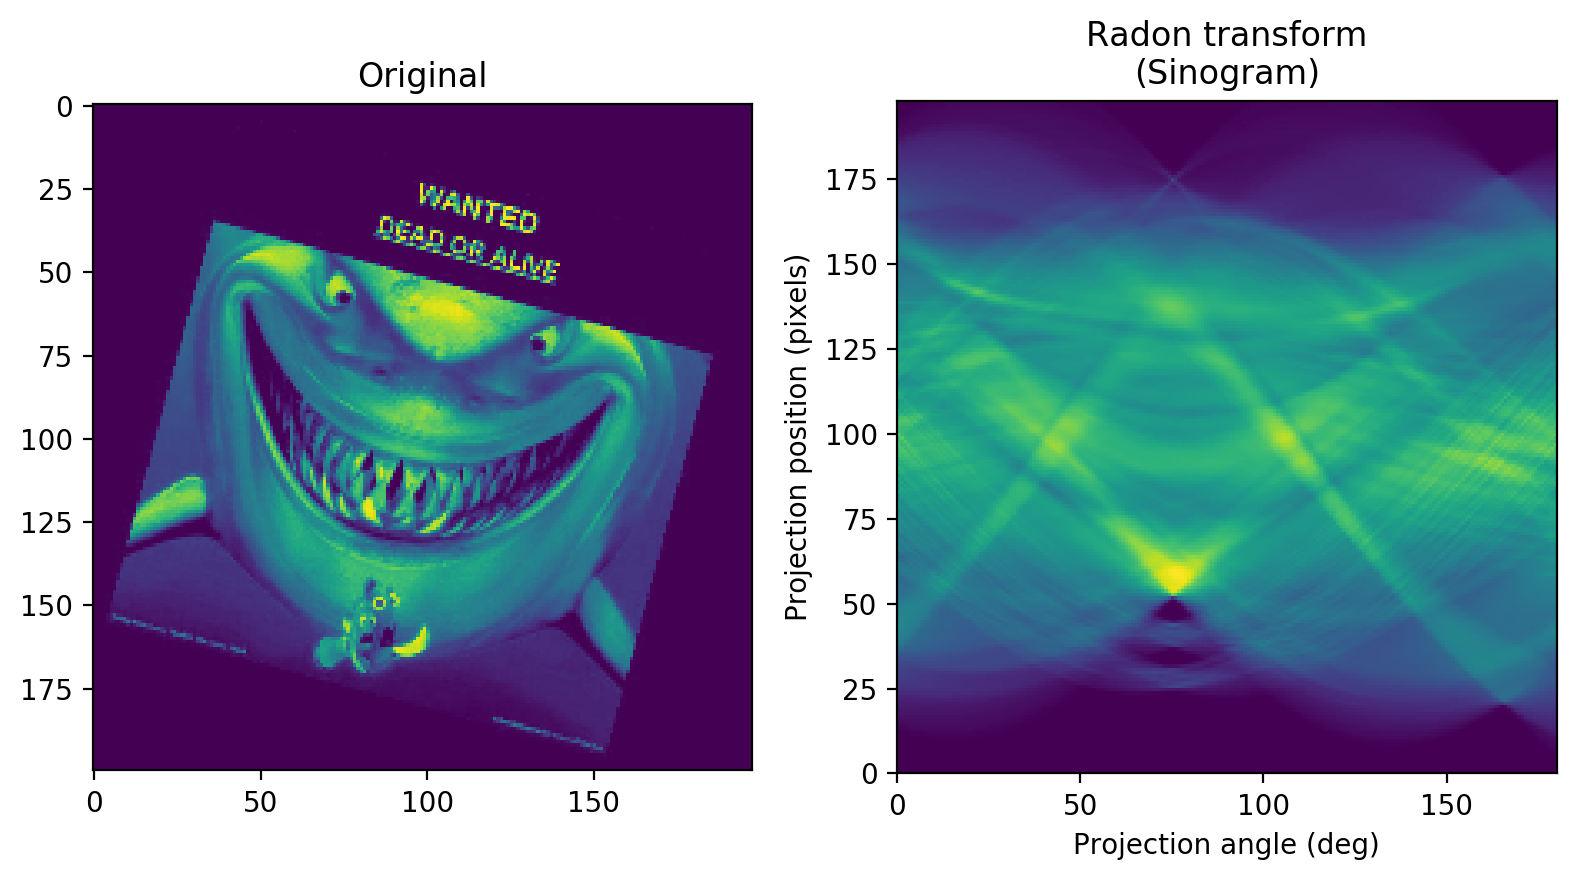

In [29]:
import numpy as np
from skimage.transform import radon, rescale

image = rescale(img, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
fig.set_dpi(200)

ax1.set_title("Original")
ax1.imshow(image)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()


The intensity peak of the transformation is ~75 ° $\implies$ the angle of the rotation to apply is 90 - 75 = 15°

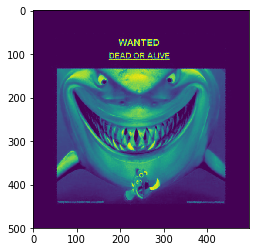

In [36]:
import skimage.transform as transform

img_rotated = transform.rotate(img, 90-75)
plt.imshow(img_rotated)
plt.show()

Let's research the exact angle to rotate

97.3566263513
angle value : 75.6°


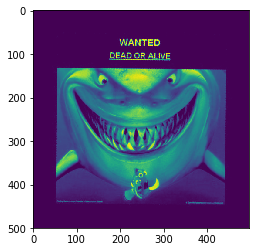

In [51]:
max_value = max(map(max, sinogram))
print(max_value)
i, j = np.where(sinogram==max_value)
angle = j[0]/sinogram.shape[1] * 180
print('angle value : {}°'.format(angle))
img_rotated = transform.rotate(img, 90-angle)
plt.imshow(img_rotated)
plt.show()

## Hough transform

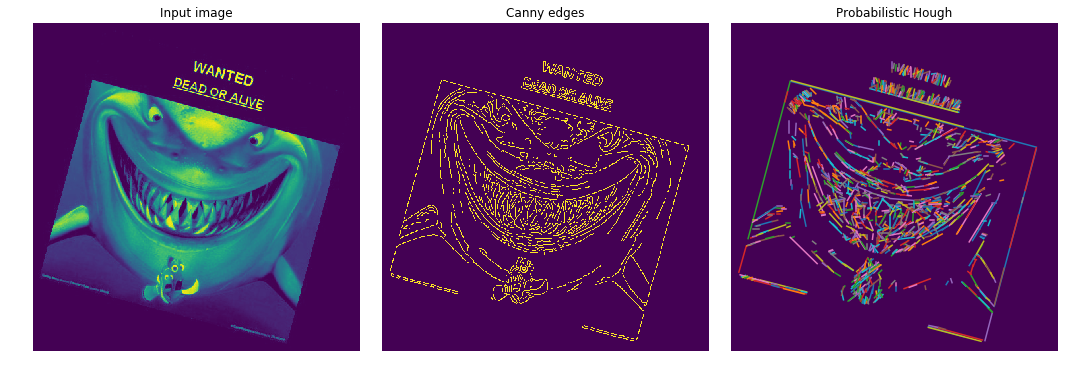

In [68]:
import numpy as np

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.color 


# Line finding using the Probabilistic Hough Transform

image = skimage.color.rgb2gray(imread('fish_rotated.jpg'))
edges = canny(image)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title('Input image')

ax[1].imshow(edges)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
    a.set_adjustable('box-forced')

plt.tight_layout()
plt.show()

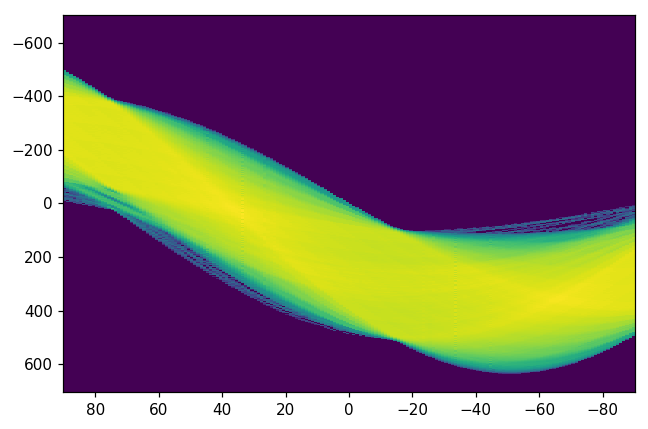

In [74]:
h, theta, d = hough_line(image)
f = plt.figure()
f.set_dpi(110)
plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]], aspect='auto')
plt.tight_layout()
plt.show()

 ## Multiresolution fish  

### Handmade Gaussian filter 

In [7]:
import numpy as np
from scipy import ndimage

def convolve_rgb(rgb_matrix, kernel):
    matrices = [rgb_matrix[:,:,0], rgb_matrix[:,:,1], rgb_matrix[:,:,2]]
    for i, matrix in enumerate(matrices):
        matrices[i] = ndimage.convolve(matrices[i], kernel)
        
    return np.dstack(matrices)

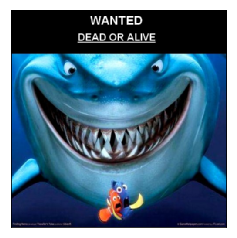

In [9]:
from skimage.filters import gaussian
from scipy import ndimage
import numpy as np
import scipy.stats as st

img=imread('fish.jpg')

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

plt.imshow(convolve_rgb(img, gkern(3, 0.4)))
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


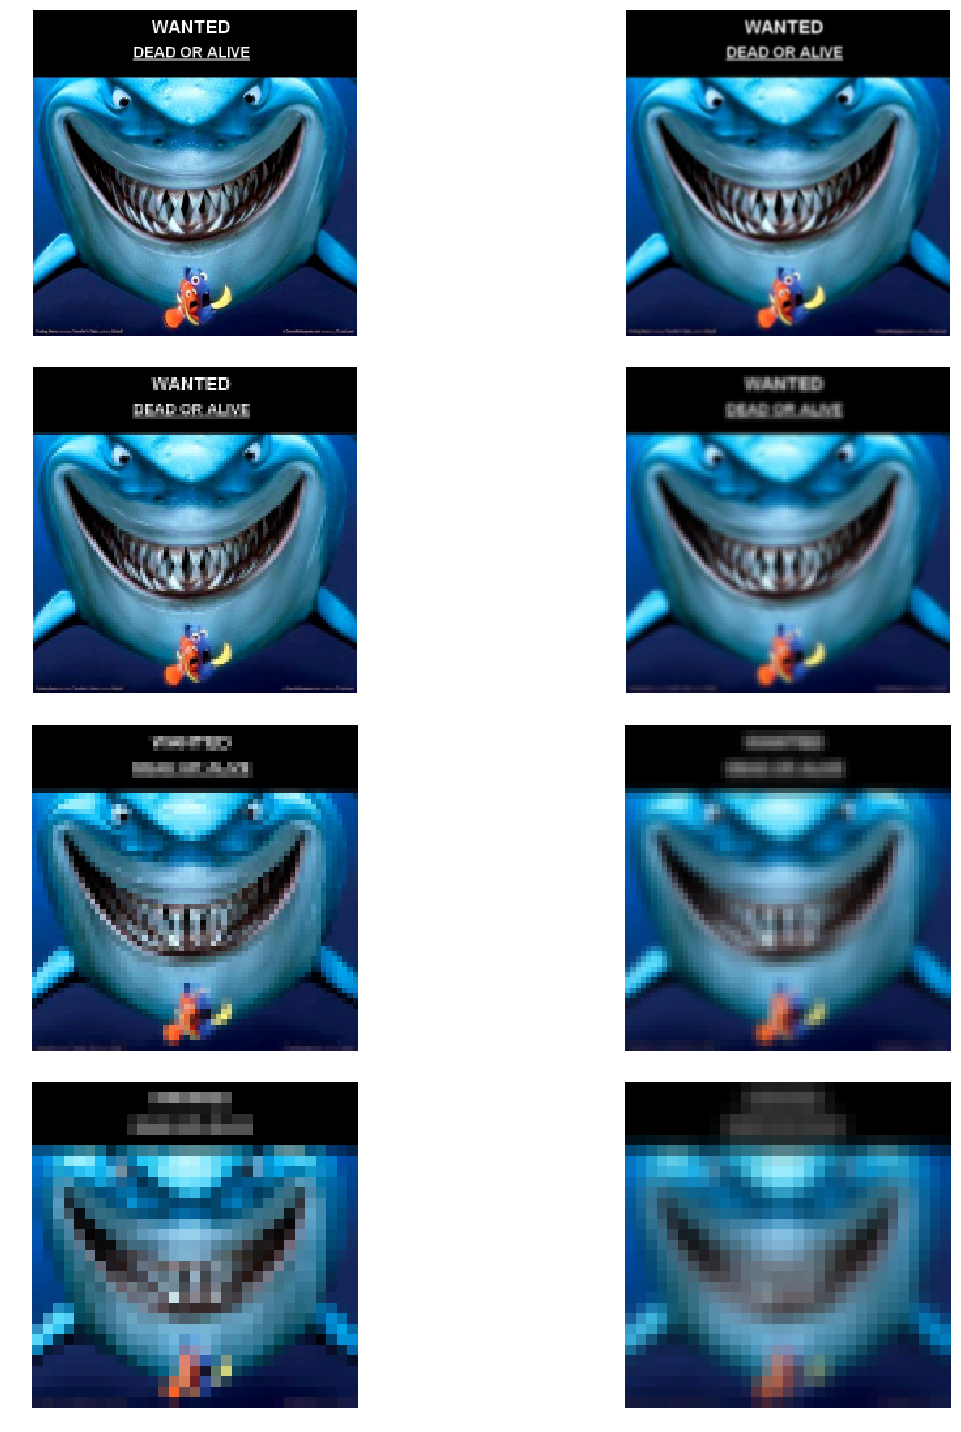

In [18]:
from skimage.filters import gaussian
from skimage.transform import resize
import numpy as np

img = imread('fish.jpg')
kernel_size = 7
sigma = 3

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
ax = axes.ravel()

for x in range(4):
    img_rescale = resize(img, [img.shape[0]//2, img.shape[1]//2, 3])
       
    rescale_gauss = resize(convolve_rgb(img, gkern(7, sigma)),
                           [img.shape[0]//2, img.shape[1]//2, 3])
        
    ax[2*x].imshow(img_rescale)
    ax[2*x].set_axis_off()
    ax[2*x].set_adjustable('box-forced')
    
    ax[(2*x)+1].imshow(rescale_gauss)
    ax[(2*x)+1].set_axis_off()
    ax[(2*x)+1].set_adjustable('box-forced')
       
    img_gauss = rescale_gauss
    img = img_rescale
    
plt.tight_layout()
plt.show()


### Gaussian pyramid (scikit image)

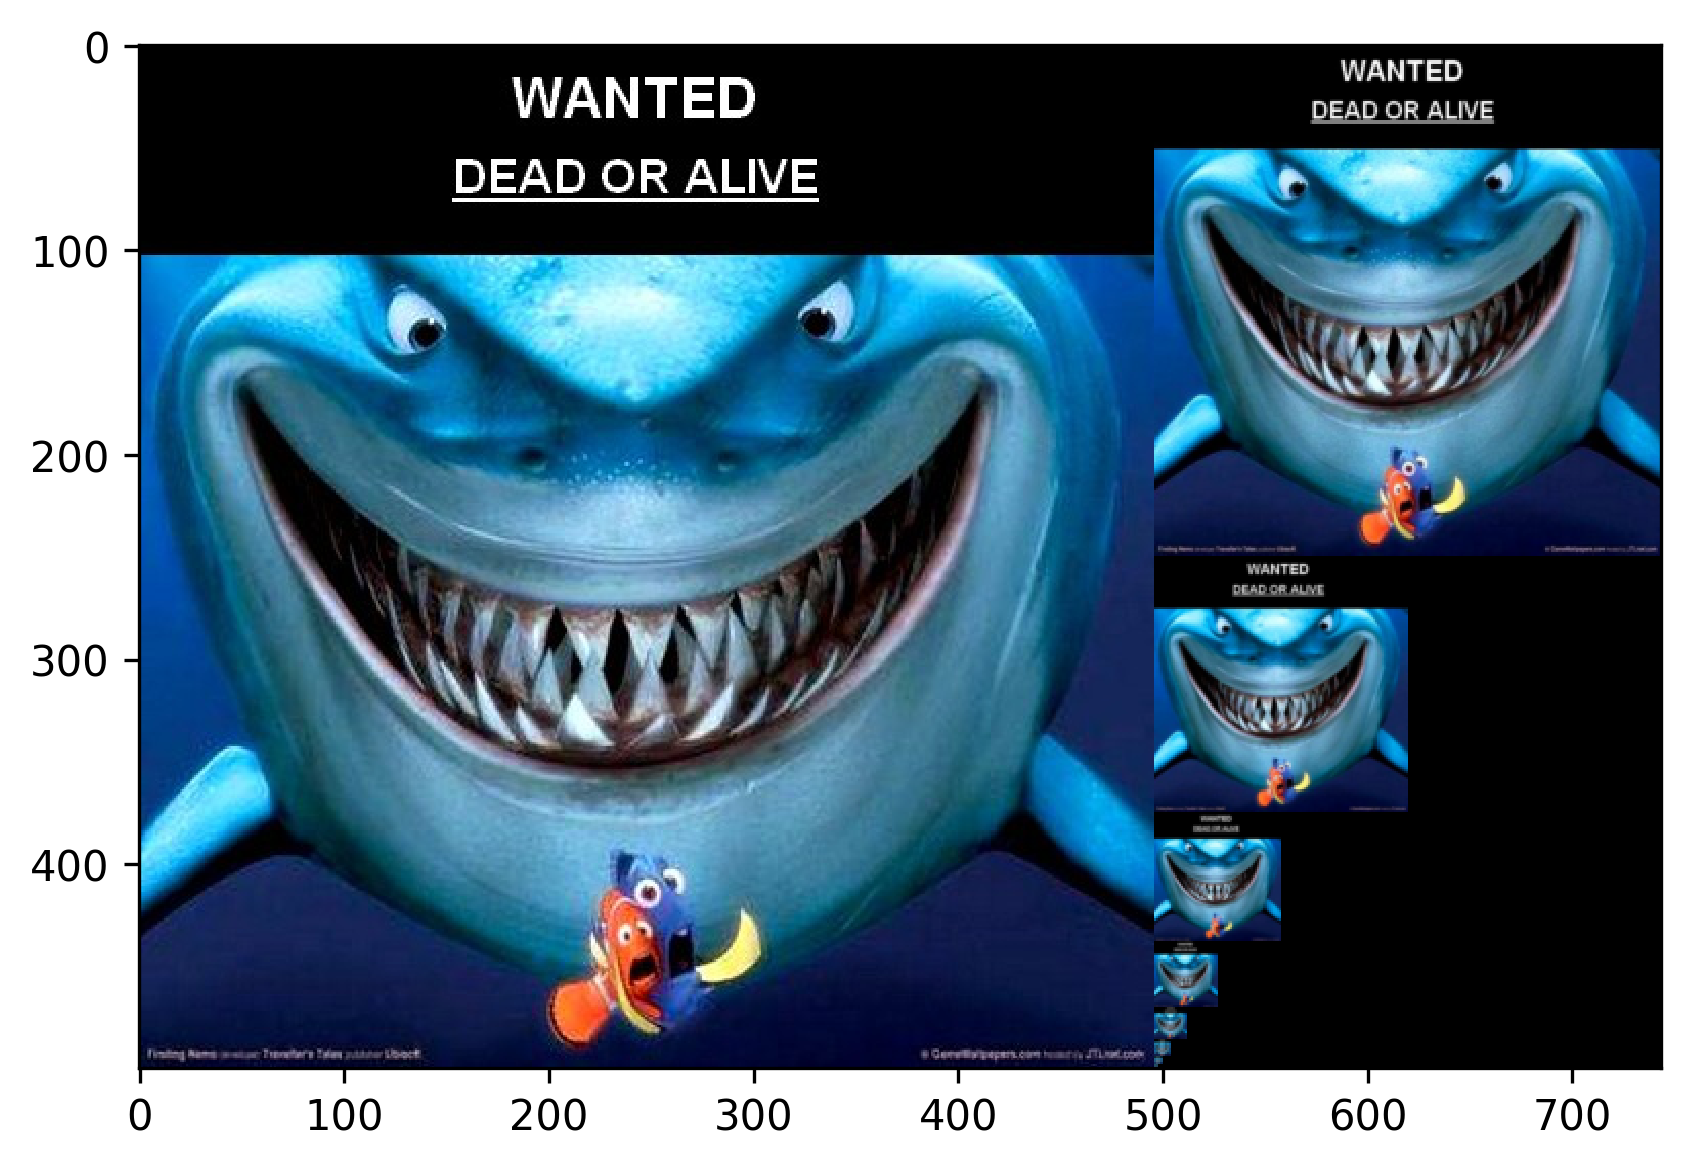

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian


image = imread('fish.jpg')
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
fig.set_dpi(300)
ax.imshow(composite_image)
plt.tight_layout()
plt.show()
